In [61]:
import pandas as pd
import folium
from folium.plugins import HeatMap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


## OVERVIEW

In the exploratory data analysis of traffic accidents in Argentina, the study began with a general numerical analysis, examining basic statistical figures to gain an initial understanding of the data. This was followed by a distribution analysis to observe patterns and outliers in variables like accident frequencies and locations. A detailed correlation analysis was conducted next, exploring relationships between different factors such as time, geography, and vehicle types. The process then involved experimenting with various graphical representations to select the most effective visualizations for the Power BI dashboard. This visualization helped in applying insights to key performance indicators (KPIs), aiding in making data-driven decisions. A notable challenge encountered was establishing correlations between weather conditions and traffic accidents, which required meticulous analysis due to the complexity of weather data and its impact on road safety.



First we merge both datasets into one for better exploratory analisis. 

In [33]:
file_path_homicides = '../Data/Processed/homicides_with_weather.csv'
file_path_victims = '../Data/Processed/df_victims_clean.csv'


homicides_weather_df = pd.read_csv(file_path_homicides)
df_victims_clean = pd.read_csv(file_path_victims)


combined_df = pd.merge(homicides_weather_df, df_victims_clean, left_on="ID", right_on="Incident_ID", how="inner")

combined_df.head()

,ID,NUMBER_OF_VICTIMS,DATE,TIME,HOUR,DATE_TIME,SUNSET,TEMPERATURE,PRECIPITATION,CLOUD_COVER,...,Incident_ID,Date,Year,Month,Day,Role,Victim,Gender,Age,Date_of_Death
0,2016-0001,1,2016-01-01,04:00:00,4,2016-01-01 04:00:00,20:10:11,24.3,rain,59.6,...,2016-0001,2016-01-01,2016,1,1,Driver,Motorcycle,Male,19,2016-01-01
1,2016-0002,1,2016-01-02,01:15:00,1,2016-01-02 01:15:00,20:10:26,26.3,NaN,60.1,...,2016-0002,2016-01-02,2016,1,2,Driver,Car,Male,70,2016-01-02
2,2016-0003,1,2016-01-03,07:00:00,7,2016-01-03 07:00:00,20:10:00,25.7,NaN,70.4,...,2016-0003,2016-01-03,2016,1,3,Driver,Motorcycle,Male,30,2016-01-03
3,2016-0004,1,2016-01-10,00:00:00,0,2016-01-10 00:00:00,20:10:28,23.1,rain,69.5,...,2016-0004,2016-01-10,2016,1,10,Driver,Motorcycle,Male,18,NaN
4,2016-0005,1,2016-01-21,05:20:00,5,2016-01-21 05:20:00,20:06:58,26.3,rain,55.0,...,2016-0005,2016-01-21,2016,1,21,Driver,Motorcycle,Male,29,2016-02-01


In [53]:
output_file_path = '../Data/Processed/combined_dataset2.csv'

# Save the combined dataset to a CSV file
combined_df.to_csv(output_file_path, index=False)

## General Flow of analysis:

- Step 1: Generate summary statistics for numerical columns.
- Step 2: Analyze the distribution of key numerical variables.
- Step 3: Correlation Analysis
- Step 4: Inquire information from dataset to be used in dashboard
- Step 5: Answer KPI's from merged data information 

**Summary Analisys:**

In [35]:
numerical_summary = combined_df.describe()

numerical_summary

,NUMBER_OF_VICTIMS,TEMPERATURE,CLOUD_COVER,HEIGHT,COMMUNE,Year,Month,Day,Age
count,717.000000,704.000000,704.000000,133.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,1.061367,18.607670,46.702131,3384.187970,7.430962,2018.174338,6.688982,15.960948,42.154812
std,0.257024,5.472757,27.867133,3095.161836,4.385067,1.672655,3.575140,8.683358,19.041627
min,1.000000,6.000000,0.000000,30.000000,0.000000,2016.000000,1.000000,1.000000,1.000000
25%,1.000000,14.200000,21.675000,1366.000000,4.000000,2017.000000,4.000000,9.000000,28.000000
50%,1.000000,18.800000,46.200000,2639.000000,8.000000,2018.000000,7.000000,16.000000,39.000000
75%,1.000000,23.100000,69.500000,4500.000000,11.000000,2019.000000,10.000000,23.000000,55.000000
max,3.000000,30.300000,100.000000,16080.000000,15.000000,2021.000000,12.000000,31.000000,95.000000


Notes: 
- TEMPERATURE and CLOUD_COVER indicate that incidents occur in varied weather conditions.

**Distribution Analysis**:
- Explore the distribution of key variables such as Age, Temperature, and Number of Victims. 


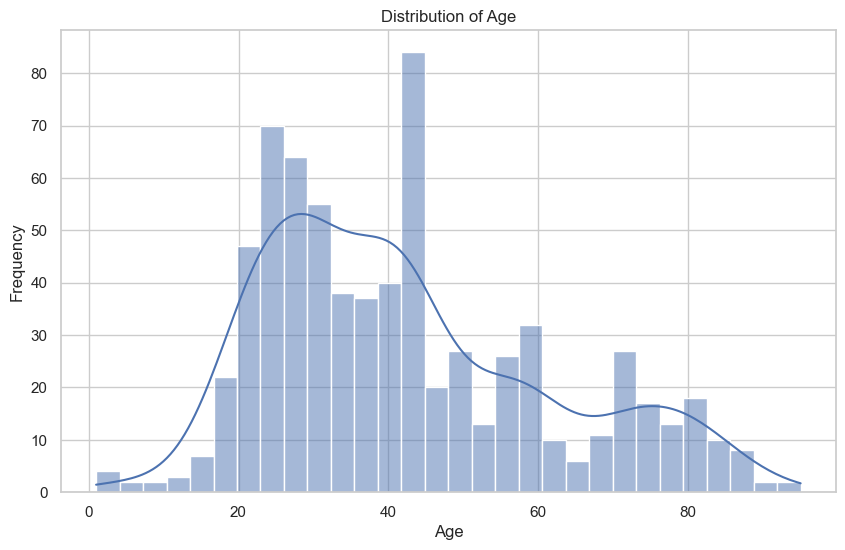

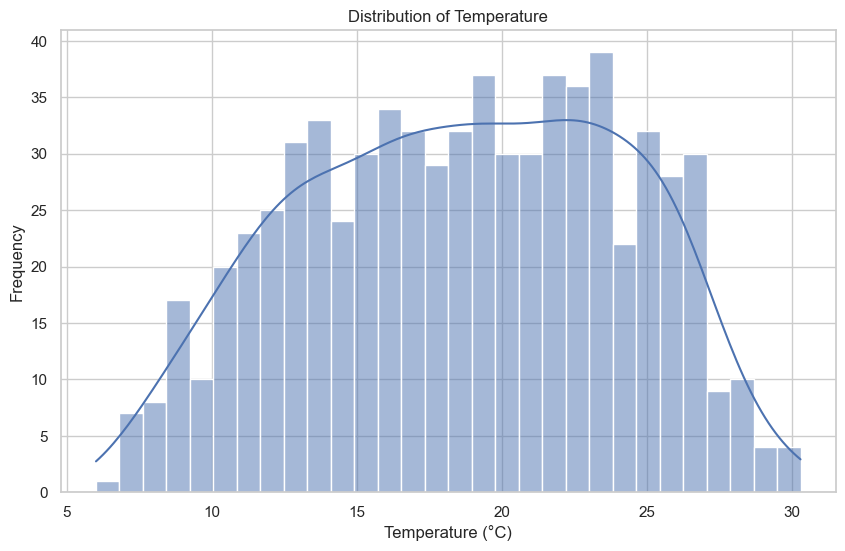

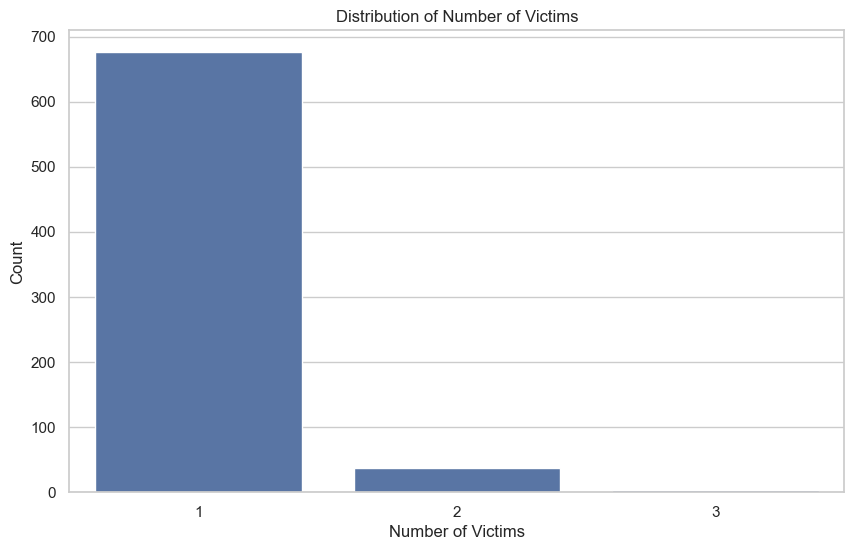

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.histplot(combined_df['Age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(combined_df['TEMPERATURE'], kde=True, bins=30)
plt.title('Distribution of Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='NUMBER_OF_VICTIMS', data=combined_df)
plt.title('Distribution of Number of Victims')
plt.xlabel('Number of Victims')
plt.ylabel('Count')   
plt.show()


**Correlation Analysis:**
- Assess if there are significant correlations between variables like Temperature, Cloud Cover, and Number of Victims. This can highlight any relationships between weather conditions and incident outcomes.

In [38]:


combined_df['PRECIPITATION'] = combined_df['PRECIPITATION'].notnull().astype(int)


time_format = 'format_string'  
combined_df['TIME'] = pd.to_datetime(combined_df['TIME'], format=time_format, errors='coerce')
combined_df['SUNSET'] = pd.to_datetime(combined_df['SUNSET'], format=time_format, errors='coerce')

def is_daytime(incident_time, sunset_time):
    if pd.isna(incident_time) or pd.isna(sunset_time):
        return np.nan
    return incident_time.time() < sunset_time.time()


combined_df['IS_DAYTIME'] = combined_df.apply(lambda row: is_daytime(row['TIME'], row['SUNSET']), axis=1)


cleaned_combined_df = combined_df.dropna(subset=['IS_DAYTIME']).copy()

cleaned_combined_df['FATALITY'] = cleaned_combined_df['Date_of_Death'].notnull().astype(int)

correlation_columns = ['TEMPERATURE', 'PRECIPITATION', 'CLOUD_COVER', 'IS_DAYTIME', 'FATALITY']
correlation_data = cleaned_combined_df[correlation_columns]

correlation_matrix = correlation_data.corr()

print(correlation_matrix)


               TEMPERATURE  PRECIPITATION  CLOUD_COVER  IS_DAYTIME  FATALITY
TEMPERATURE       1.000000            NaN    -0.125487    0.135187  0.083753
PRECIPITATION          NaN            NaN          NaN         NaN       NaN
CLOUD_COVER      -0.125487            NaN     1.000000   -0.022628 -0.010409
IS_DAYTIME        0.135187            NaN    -0.022628    1.000000  0.073479
FATALITY          0.083753            NaN    -0.010409    0.073479  1.000000


**Summary of Correlation Analysis Findings** 
- Temperature and Fatalities: A positive correlation (0.083753) was observed between temperature and fatalities. This suggests that higher temperatures might be associated with an increased number of fatalities. However, the correlation is relatively weak, indicating that other factors also play significant roles.

- Cloud Cover and Fatalities: Cloud cover showed a very weak negative correlation (-0.010409) with fatalities. This implies that there is little to no direct relationship between the amount of cloud cover and the number of fatalities in traffic incidents.

- Temperature and Cloud Cover: There is a weak negative correlation (-0.125487) between temperature and cloud cover. This might indicate that higher temperatures are slightly more likely to occur on days with less cloud cover.

- Daytime vs. Nighttime (IS_DAYTIME) and Fatalities: The correlation between daytime/nighttime and fatalities is weakly positive (0.073479), suggesting a slight increase in fatalities during daytime. However, this correlation is not strong enough to draw definitive conclusions.

- Daytime vs. Nighttime (IS_DAYTIME) and Temperature: A positive correlation (0.135187) is observed here, indicating higher temperatures are more common during the daytime. This is an expected result, aligning with general knowledge about daily temperature variations.

- Limitation in Precipitation Data: The PRECIPITATION column, after being converted to a binary variable (indicating the presence or absence of precipitation), showed NaN values in the correlation matrix. This is likely due to the lack of variation in the data, as most values were zeros (indicating 'None'). This limitation prevents meaningful correlation analysis for precipitation.

General Observation: The correlations observed are generally weak, suggesting that while there may be some relationships between these variables and traffic incident fatalities, they are not strong. Other unexamined factors may also play significant roles in influencing these outcomes.

## **Inquiries for dashboard**

Total number of incidents per year

Total number of incidents: 717

Total number of incidents per year:
Year
2016    146
2017    140
2018    149
2019    104
2020     81
2021     97
Name: count, dtype: int64


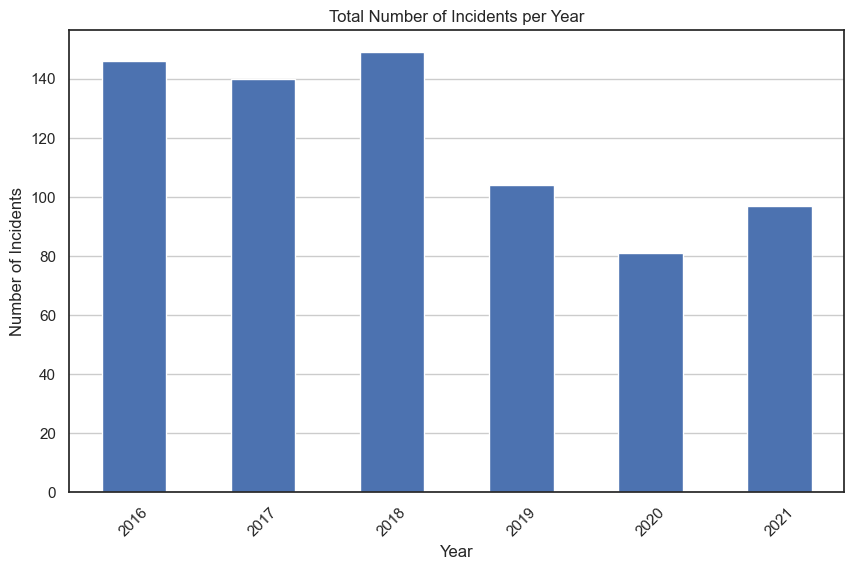

In [41]:
total_incidents = len(combined_df)
print(f"Total number of incidents: {total_incidents}")

incidents_per_year = combined_df['Year'].value_counts().sort_index()

print("\nTotal number of incidents per year:")
print(incidents_per_year)

plt.figure(figsize=(10, 6))
incidents_per_year.plot(kind='bar')
plt.title('Total Number of Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Total number of incidents during day and night:

Total number of incidents (Day and Night):
DAY_OR_NIGHT
Day        560
Night      143
Unknown     14
Name: count, dtype: int64


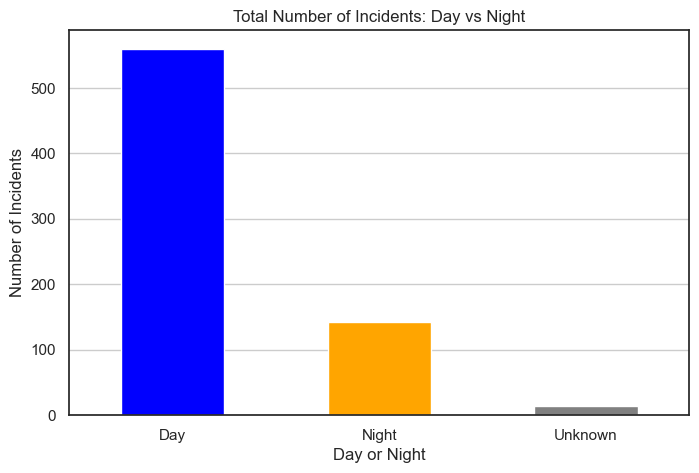

In [42]:

combined_df['TIME'] = pd.to_datetime(combined_df['TIME'].astype(str), errors='coerce')
combined_df['SUNSET'] = pd.to_datetime(combined_df['SUNSET'].astype(str), errors='coerce')


def classify_day_night(incident_time, sunset_time):
    if pd.isna(incident_time) or pd.isna(sunset_time):
        return "Unknown"
    return "Day" if incident_time.time() < sunset_time.time() else "Night"

combined_df['DAY_OR_NIGHT'] = combined_df.apply(
    lambda row: classify_day_night(row['TIME'], row['SUNSET']), axis=1)

incidents_day_night = combined_df['DAY_OR_NIGHT'].value_counts()

print("Total number of incidents (Day and Night):")
print(incidents_day_night)

plt.figure(figsize=(8, 5))
incidents_day_night.plot(kind='bar', color=['blue', 'orange', 'grey'])
plt.title('Total Number of Incidents: Day vs Night')
plt.xlabel('Day or Night')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [45]:
if 'Year' not in combined_df.columns:
    combined_df['Year'] = pd.to_datetime(combined_df['DATE']).dt.year

incidents_year_day_night = combined_df.groupby(['Year', 'DAY_OR_NIGHT']).size().unstack(fill_value=0)

incidents_year_day_night




DAY_OR_NIGHT,Day,Night,Unknown
Year,,,
2016,108,34,4
2017,108,27,5
2018,116,32,1
2019,83,20,1
2020,63,16,2
2021,82,14,1


<Figure size 1000x600 with 0 Axes>

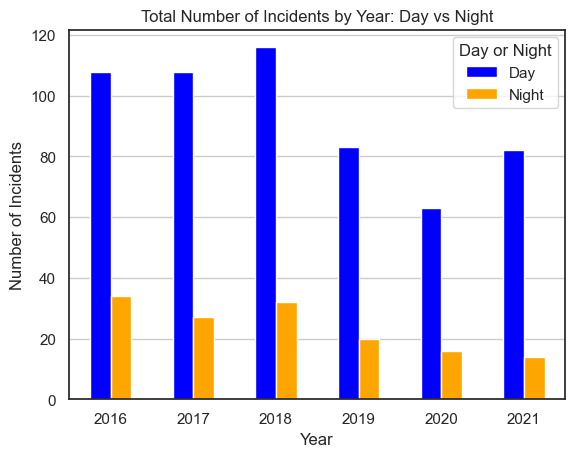

In [47]:
plt.figure(figsize=(10, 6))
incidents_year_day_night[['Day', 'Night']].plot(kind='bar', color=['blue', 'orange'])
plt.title('Total Number of Incidents by Year: Day vs Night')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Day or Night')
plt.show()

**Mortalities**

Total number of fatalities: 649

Total number of fatalities per year:
Year
2016     84
2017    134
2018    149
2019    104
2020     81
2021     97
Name: FATALITY, dtype: int32


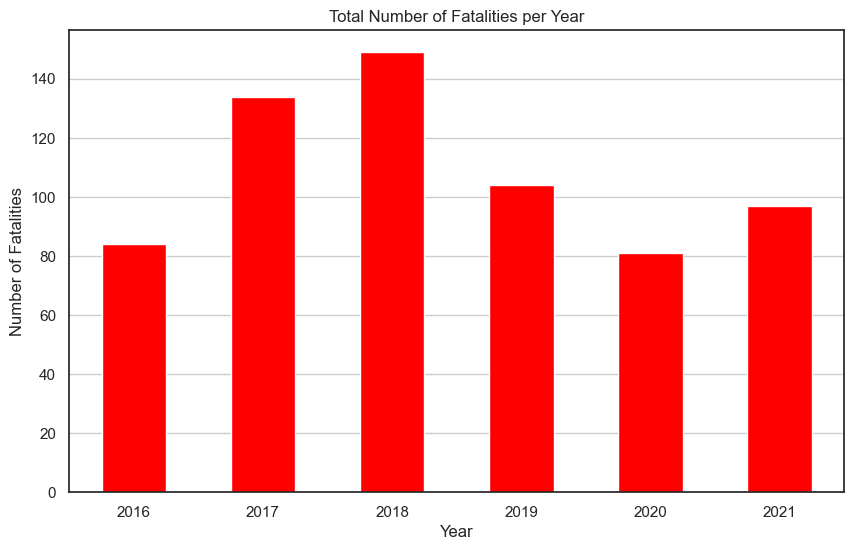

In [48]:
combined_df['FATALITY'] = combined_df['Date_of_Death'].notnull().astype(int)

total_fatalities = combined_df['FATALITY'].sum()
print(f"Total number of fatalities: {total_fatalities}")
fatalities_per_year = combined_df.groupby('Year')['FATALITY'].sum()

print("\nTotal number of fatalities per year:")
print(fatalities_per_year)

plt.figure(figsize=(10, 6))
fatalities_per_year.plot(kind='bar', color='red')
plt.title('Total Number of Fatalities per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fatalities')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()



In [50]:

fatalities_year_day_night = combined_df.groupby(['Year', 'DAY_OR_NIGHT'])['FATALITY'].sum().unstack(fill_value=0)

fatalities_percentage = fatalities_year_day_night.div(fatalities_year_day_night.sum(axis=1), axis=0) * 100

print(fatalities_percentage)


DAY_OR_NIGHT        Day      Night   Unknown
Year                                        
2016          78.571429  21.428571  0.000000
2017          78.358209  17.910448  3.731343
2018          77.852349  21.476510  0.671141
2019          79.807692  19.230769  0.961538
2020          77.777778  19.753086  2.469136
2021          84.536082  14.432990  1.030928


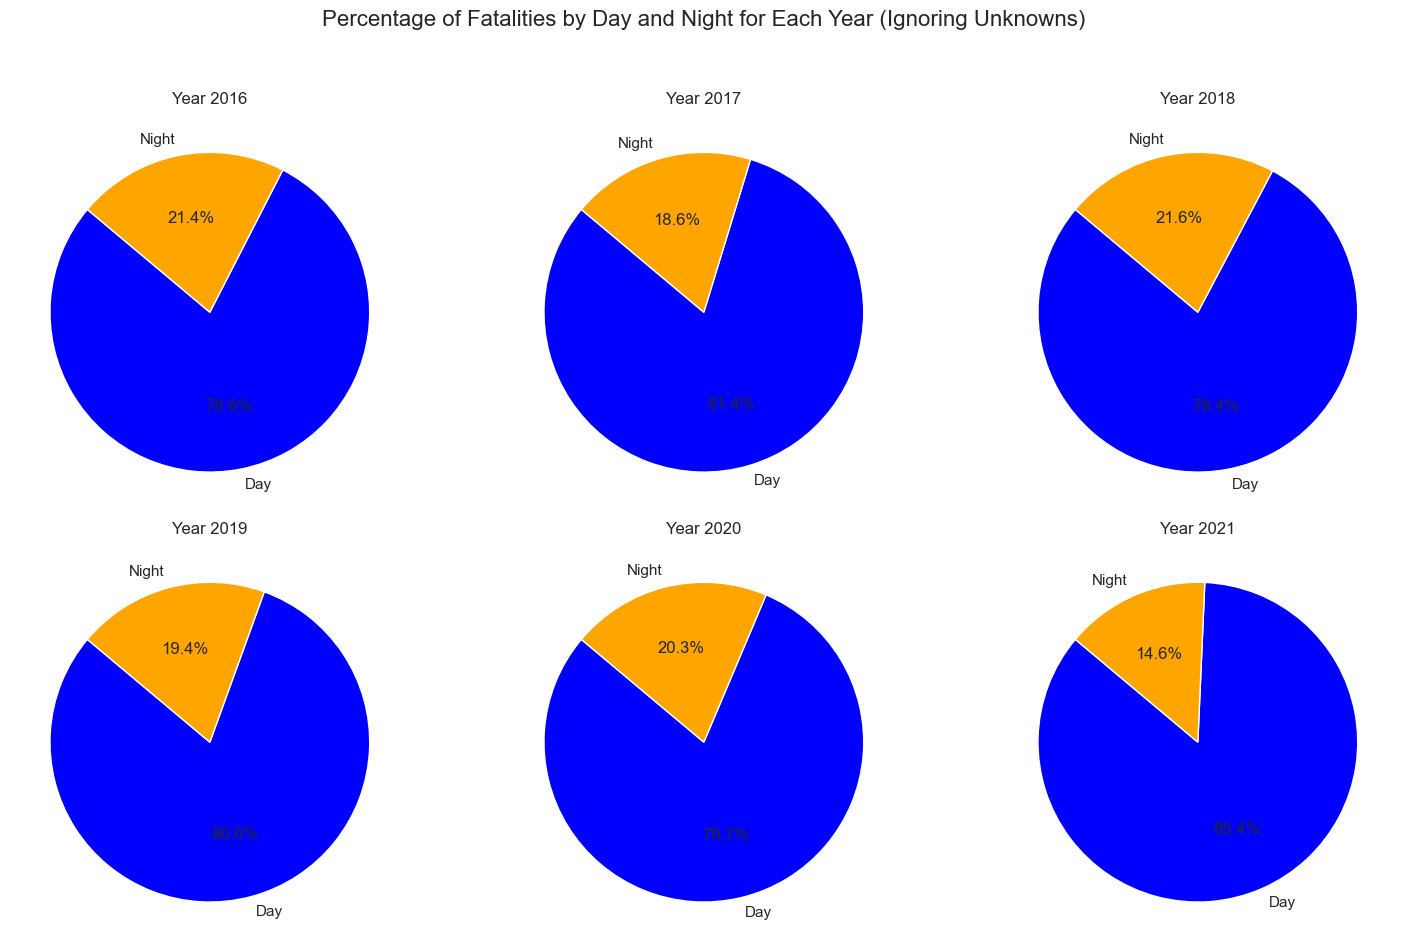

In [51]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Percentage of Fatalities by Day and Night for Each Year (Ignoring Unknowns)', fontsize=16)

for i, (year, data) in enumerate(fatalities_percentage.iterrows()):
    ax = axes[i // 3, i % 3]
    data = data[['Day', 'Night']]  
    ax.pie(data, labels=['Day', 'Night'], autopct='%1.1f%%', startangle=140, colors=['blue', 'orange'])
    ax.set_title(f'Year {year}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



**Victim analisys** 
- Most Common Victims: The bar chart shows the distribution of different victim types in the dataset. Each bar represents the number of incidents involving each type of victim, providing insights into which groups are most commonly affected.

- Age Dispersion of Victims: The histogram displays the age distribution of the victims. It gives a clear idea of which age groups are most frequently involved in incidents, with the number of victims plotted against their ages.

- Gender Distribution: The pie chart illustrates the gender distribution of the victims. The percentages represent the proportion of male and female victims in the dataset.

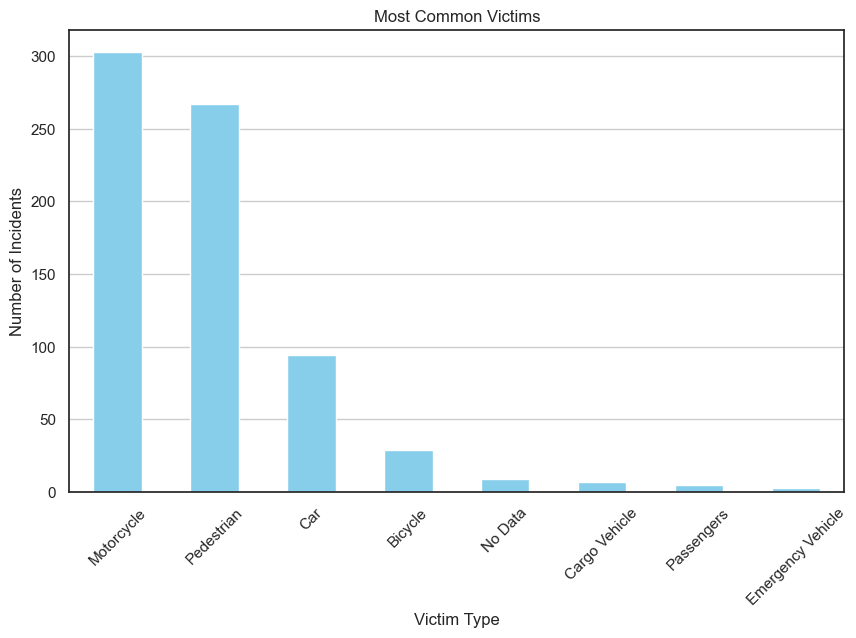

In [56]:
import matplotlib.pyplot as plt

victim_counts = combined_df['Victim'].value_counts()
plt.figure(figsize=(10, 6))
victim_counts.plot(kind='bar', color='skyblue')
plt.title('Most Common Victims')
plt.xlabel('Victim Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


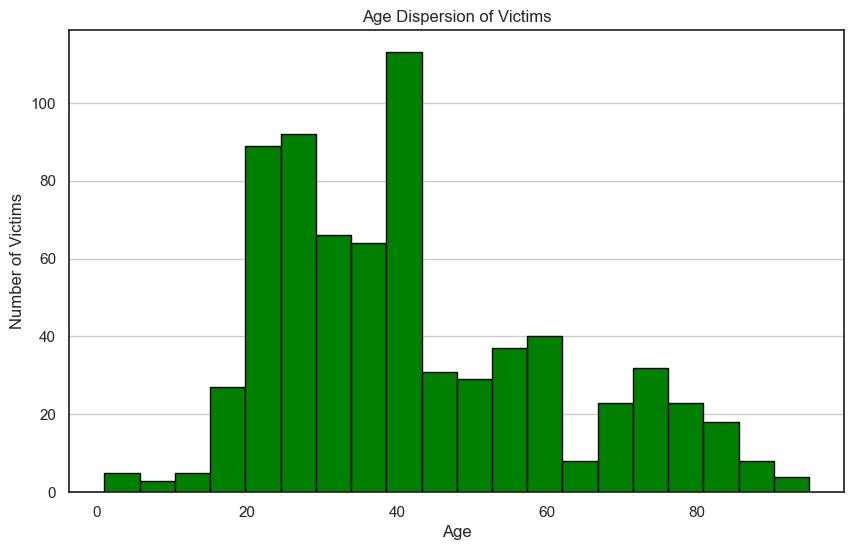

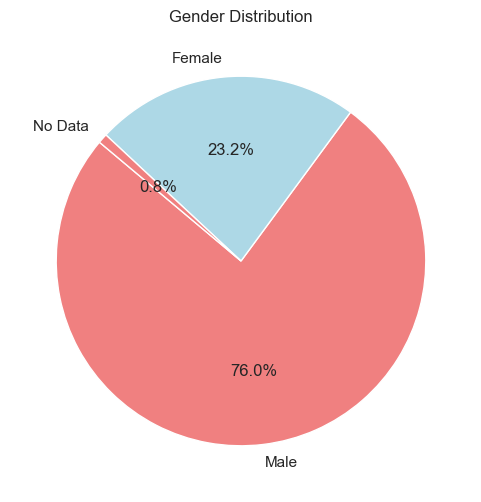

In [55]:

plt.figure(figsize=(10, 6))
combined_df['Age'].plot(kind='hist', bins=20, color='green', edgecolor='black')
plt.title('Age Dispersion of Victims')
plt.xlabel('Age')
plt.ylabel('Number of Victims')
plt.grid(axis='y')
plt.show()


gender_counts = combined_df['Gender'].value_counts()
plt.figure(figsize=(6, 6))
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightblue'])
plt.title('Gender Distribution')
plt.ylabel('')  
plt.show()




In [52]:
combined_df.head()

,ID,NUMBER_OF_VICTIMS,DATE,TIME,HOUR,DATE_TIME,SUNSET,TEMPERATURE,PRECIPITATION,CLOUD_COVER,...,Month,Day,Role,Victim,Gender,Age,Date_of_Death,IS_DAYTIME,DAY_OR_NIGHT,FATALITY
0,2016-0001,1,2016-01-01,2024-01-16 04:00:00,4,2016-01-01 04:00:00,2024-01-16 20:10:11,24.3,1,59.6,...,1,1,Driver,Motorcycle,Male,19,2016-01-01,True,Day,1
1,2016-0002,1,2016-01-02,2024-01-16 01:15:00,1,2016-01-02 01:15:00,2024-01-16 20:10:26,26.3,1,60.1,...,1,2,Driver,Car,Male,70,2016-01-02,True,Day,1
2,2016-0003,1,2016-01-03,2024-01-16 07:00:00,7,2016-01-03 07:00:00,2024-01-16 20:10:00,25.7,1,70.4,...,1,3,Driver,Motorcycle,Male,30,2016-01-03,True,Day,1
3,2016-0004,1,2016-01-10,2024-01-16 00:00:00,0,2016-01-10 00:00:00,2024-01-16 20:10:28,23.1,1,69.5,...,1,10,Driver,Motorcycle,Male,18,NaN,True,Day,0
4,2016-0005,1,2016-01-21,2024-01-16 05:20:00,5,2016-01-21 05:20:00,2024-01-16 20:06:58,26.3,1,55.0,...,1,21,Driver,Motorcycle,Male,29,2016-02-01,True,Day,1


**Time of day**:
- Categorize the incidents into different parts of the day. Common categories include morning (6:00-12:00), afternoon (12:00-18:00), evening (18:00-24:00), and night (0:00-6:00).

C:\Users\sarmi\AppData\Local\Temp\ipykernel_23880\216794284.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  combined_df['TIME'] = pd.to_datetime(combined_df['TIME'].astype(str), errors='coerce').dt.time


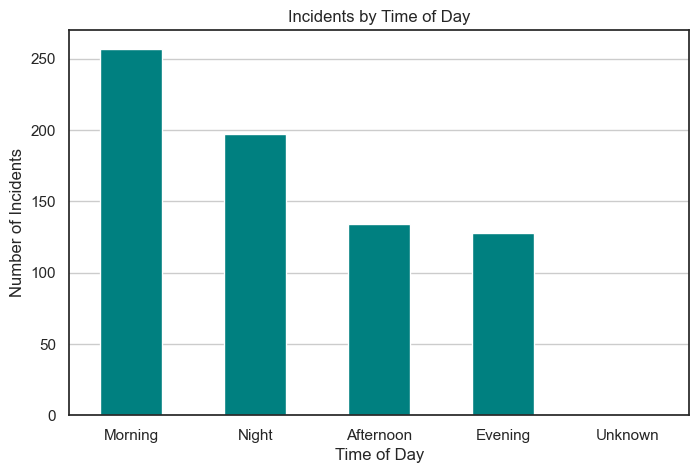

In [62]:

time_slots = {
    'Morning': ('05:00:00', '12:00:00'),
    'Afternoon': ('12:00:00', '17:00:00'),
    'Evening': ('17:00:00', '21:00:00'),
    'Night': ('21:00:00', '05:00:00')
}


def string_to_time(time_str):
    return datetime.strptime(time_str, '%H:%M:%S').time()


for slot in time_slots:
    start, end = time_slots[slot]
    time_slots[slot] = (string_to_time(start), string_to_time(end))


def categorize_time_of_day(time):
    if pd.isna(time):  
        return 'Unknown'
    for slot, (start, end) in time_slots.items():
        if start < end:
            if start <= time <= end:
                return slot
        else:  
            if time >= start or time <= end:
                return slot
    return 'Unknown'


combined_df['TIME'] = pd.to_datetime(combined_df['TIME'].astype(str), errors='coerce').dt.time
combined_df['TIME_SLOT'] = combined_df['TIME'].apply(categorize_time_of_day)


time_of_day_counts = combined_df['TIME_SLOT'].value_counts()
plt.figure(figsize=(8, 5))
time_of_day_counts.plot(kind='bar', color='teal')
plt.title('Incidents by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

**Location of events:** 

In [64]:

top_n = 10  
location_counts = combined_df['PLACE_OF_EVENT'].value_counts().head(top_n)


print(location_counts)

PLACE_OF_EVENT
AV 27 DE FEBRERO Y AV ESCALADA                                 4
AV. DR. TRISTAN ACHAVAL RODRIGUEZ Y BLVD. AZUCENA VILLAFLOR    3
AU PERITO MORENO Y RAMAL ENLACE AU1/AU6                        2
CASTILLO, RAMON S., PRES. AV. Y CALLE 12                       2
Rivadavia Av. y Pedernera                                      2
PAZ, GRAL. AV. Y DEL LIBERTADOR AV.                            2
AV. RIVADAVIA 1571                                             2
LAS HERAS GENERAL AV. Y DIAZ, CNEL. AV.                        2
AV. GRAL. PAZ Y MACHAIN                                        2
Rabanal, Francisco, Intendente Av. y Saenz Av.                 2
Name: count, dtype: int64


## KPI analysis 

KPI 1: Reduce the rate of homicides in traffic accidents by 10% in the last six months in CABA (Ciudad Autónoma de Buenos Aires), compared to the rate of homicides in traffic accidents from the previous semester.

We define the rate of homicides in traffic accidents as the number of fatal victims in traffic accidents per 100,000 inhabitants in a geographical area during a specific period. The formula is: (Number of homicides in traffic accidents / Total population) * 100,000"

Population: 3,121,707 inhabitants.

In [68]:

combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])


most_recent_date = combined_df['DATE'].max()


last_six_months_end = most_recent_date
last_six_months_start = last_six_months_end - pd.DateOffset(months=6)
previous_semester_end = last_six_months_start - pd.DateOffset(days=1)
previous_semester_start = previous_semester_end - pd.DateOffset(months=6)


fatal_accidents = combined_df[combined_df['Date_of_Death'].notnull()]


fatal_accidents_last_six_months = fatal_accidents[(fatal_accidents['DATE'] >= last_six_months_start) & (fatal_accidents['DATE'] <= last_six_months_end)]
fatal_accidents_previous_semester = fatal_accidents[(fatal_accidents['DATE'] >= previous_semester_start) & (fatal_accidents['DATE'] <= previous_semester_end)]


num_fatalities_last_six_months = len(fatal_accidents_last_six_months)
num_fatalities_previous_semester = len(fatal_accidents_previous_semester)


population = 3121707


rate_last_six_months = (num_fatalities_last_six_months / population) * 100000
rate_previous_semester = (num_fatalities_previous_semester / population) * 100000


percentage_change = ((rate_last_six_months - rate_previous_semester) / rate_previous_semester) * 100


print(f"Most recent date: {most_recent_date}")
print(f"Last six months period: {last_six_months_start} to {last_six_months_end}")
print(f"Previous semester period: {previous_semester_start} to {previous_semester_end}")
print(f"Number of fatalities in the last six months: {num_fatalities_last_six_months}")
print(f"Number of fatalities in the previous semester: {num_fatalities_previous_semester}")
print(f"Rate of homicides in the last six months per 100,000 inhabitants: {rate_last_six_months}")
print(f"Rate of homicides in the previous semester per 100,000 inhabitants: {rate_previous_semester}")
print(f"Percentage change in the rate of homicides: {percentage_change}%")

Most recent date: 2021-12-30 00:00:00
Last six months period: 2021-06-30 00:00:00 to 2021-12-30 00:00:00
Previous semester period: 2020-12-29 00:00:00 to 2021-06-29 00:00:00
Number of fatalities in the last six months: 42
Number of fatalities in the previous semester: 55
Rate of homicides in the last six months per 100,000 inhabitants: 1.345417747405506
Rate of homicides in the previous semester per 100,000 inhabitants: 1.7618565739834007
Percentage change in the rate of homicides: -23.636363636363633%


Check if the target reduction of 10% has been achieve

In [69]:
kpi_target_reduction = -10  
kpi_achieved = percentage_change <= kpi_target_reduction

kpi_achieved, percentage_change

(True, -23.636363636363633)

**KPI 2:**

Reduce the number of fatal motorcycle accidents by 7% in the last year in CABA (Ciudad Autónoma de Buenos Aires), compared to the previous year. We define the number of fatal motorcycle accidents in traffic incidents as the absolute number of fatal accidents involving victims who were traveling on a motorcycle during a specific period. 

The formula to measure the evolution of fatal accidents with motorcycle victims is: 

( Number of fatal accidents with motorcycle victims in the previous year − Number of fatal accidents with motorcycle victims in the current year) /
( Number of fatal accidents with motorcycle victims in the previous year) × 100 (Number of fatal accidents with motorcycle victims in the previous year−Number of fatal accidents with motorcycle victims in the current year)/(Number of fatal accidents with motorcycle victims in the previous year)×100

In [70]:

combined_df['DATE'] = pd.to_datetime(combined_df['DATE'])
combined_df['Date_of_Death'] = pd.to_datetime(combined_df['Date_of_Death'])


most_recent_date = combined_df['DATE'].max()


last_year_end = most_recent_date
last_year_start = last_year_end - pd.DateOffset(years=1)
year_before_last_end = last_year_start - pd.DateOffset(days=1)
year_before_last_start = year_before_last_end - pd.DateOffset(years=1)

fatal_accidents = combined_df[combined_df['Date_of_Death'].notnull()]

motorcycle_fatal_accidents = fatal_accidents[fatal_accidents['Victim'] == 'Motorcycle']

motorcycle_fatal_accidents_last_year = motorcycle_fatal_accidents[(motorcycle_fatal_accidents['DATE'] >= last_year_start) & (motorcycle_fatal_accidents['DATE'] <= last_year_end)]
motorcycle_fatal_accidents_year_before_last = motorcycle_fatal_accidents[(motorcycle_fatal_accidents['DATE'] >= year_before_last_start) & (motorcycle_fatal_accidents['DATE'] <= year_before_last_end)]

num_motorcycle_fatalities_last_year = len(motorcycle_fatal_accidents_last_year)
num_motorcycle_fatalities_year_before_last = len(motorcycle_fatal_accidents_year_before_last)

motorcycle_accidents_percentage_change = ((num_motorcycle_fatalities_year_before_last - num_motorcycle_fatalities_last_year) / num_motorcycle_fatalities_year_before_last) * 100

# Output the results
print(f"Last year period: {last_year_start} to {last_year_end}")
print(f"Year before last period: {year_before_last_start} to {year_before_last_end}")
print(f"Number of fatal motorcycle accidents in the last year: {num_motorcycle_fatalities_last_year}")
print(f"Number of fatal motorcycle accidents in the year before last: {num_motorcycle_fatalities_year_before_last}")
print(f"Percentage change in the number of fatal motorcycle accidents: {motorcycle_accidents_percentage_change}%")


Last year period: 2020-12-30 00:00:00 to 2021-12-30 00:00:00
Year before last period: 2019-12-29 00:00:00 to 2020-12-29 00:00:00
Number of fatal motorcycle accidents in the last year: 46
Number of fatal motorcycle accidents in the year before last: 29
Percentage change in the number of fatal motorcycle accidents: -58.620689655172406%


Check the KPI:

In [71]:
kpi_motorcycle_target_reduction = -7  
kpi_motorcycle_achieved = motorcycle_accidents_percentage_change <= kpi_motorcycle_target_reduction

kpi_motorcycle_achieved, motorcycle_accidents_percentage_change

(True, -58.620689655172406)

**KPI 3 : Nighttime Traffic Accident Reduction KPI**

focused on reducing the rate of nighttime traffic accidents. For the purpose of this KPI, 'nighttime' is defined as any period occurring **after sunset**. This approach allows to specifically target the unique conditions and challenges that arise during nighttime driving, such as reduced visibility and increased fatigue among drivers.

This KPI aims to achieve a **5% reduction** in the rate of nighttime traffic accidents in *Ciudad Autónoma de Buenos Aires (CABA)*. To effectively measure the progress, the following formula was used:

Percentage Change in Nighttime Accident Rate = ((Rate in the previous period - Rate in the current period) / Rate in the previous period) × 100%


Here, the 'Rate of Nighttime Accidents' is calculated as the number of nighttime accidents per 100,000 inhabitants, based on CABA's population of 3,121,707. By comparing the rate of nighttime accidents between two equivalent time periods (the current period versus the previous period), this KPI provides a clear and quantifiable measure of our success in reducing nighttime traffic accidents.




In [79]:

nighttime_accidents = combined_df[combined_df['DAY_OR_NIGHT'] == 'Night']


most_recent_date = combined_df['DATE'].max()
current_year_end = most_recent_date
current_year_start = current_year_end - pd.DateOffset(years=1)
previous_year_end = current_year_start - pd.DateOffset(days=1)
previous_year_start = previous_year_end - pd.DateOffset(years=1)

nighttime_accidents_current_year = nighttime_accidents[(nighttime_accidents['DATE'] >= current_year_start) & (nighttime_accidents['DATE'] <= current_year_end)]
nighttime_accidents_previous_year = nighttime_accidents[(nighttime_accidents['DATE'] >= previous_year_start) & (nighttime_accidents['DATE'] <= previous_year_end)]


num_nighttime_accidents_current_year = len(nighttime_accidents_current_year)
num_nighttime_accidents_previous_year = len(nighttime_accidents_previous_year)

population = 3121707  
rate_nighttime_accidents_current_year = (num_nighttime_accidents_current_year / population) * 100000
rate_nighttime_accidents_previous_year = (num_nighttime_accidents_previous_year / population) * 100000

percentage_change_nighttime_accidents = ((rate_nighttime_accidents_previous_year - rate_nighttime_accidents_current_year) / rate_nighttime_accidents_previous_year) * 100

print(f"Current year period: {current_year_start} to {current_year_end}")
print(f"Previous year period: {previous_year_start} to {previous_year_end}")
print(f"Number of nighttime accidents in the current year: {num_nighttime_accidents_current_year}")
print(f"Number of nighttime accidents in the previous year: {num_nighttime_accidents_previous_year}")
print(f"Rate of nighttime accidents in the current year per 100,000 inhabitants: {rate_nighttime_accidents_current_year}")
print(f"Rate of nighttime accidents in the previous year per 100,000 inhabitants: {rate_nighttime_accidents_previous_year}")
print(f"Percentage change in the rate of nighttime accidents: {percentage_change_nighttime_accidents}%")


Current year period: 2020-12-30 00:00:00 to 2021-12-30 00:00:00
Previous year period: 2019-12-29 00:00:00 to 2020-12-29 00:00:00
Number of nighttime accidents in the current year: 14
Number of nighttime accidents in the previous year: 16
Rate of nighttime accidents in the current year per 100,000 inhabitants: 0.448472582468502
Rate of nighttime accidents in the previous year per 100,000 inhabitants: 0.5125400942497166
Percentage change in the rate of nighttime accidents: 12.499999999999996%


Check KPI:

In [80]:
kpi_nighttime_target_reduction = -5  
kpi_nighttime_achieved = percentage_change_nighttime_accidents <= kpi_nighttime_target_reduction


print("KPI Achieved:", kpi_nighttime_achieved)
print("Percentage Change in Nighttime Accidents:", percentage_change_nighttime_accidents)


KPI Achieved: False
Percentage Change in Nighttime Accidents: 12.499999999999996
